# Calage sur le cas crue par régression linéaire

Dans ce texte, nous réalisons le calage d'un modèle de hauteurs d'eau.

Modèle : Cas Crue

### Références

* http://openturns.github.io/openturns/1.11/examples/flood_model.html
* http://openturns.github.io/openturns/1.11/theory/reliability_sensitivity/monte_carlo_simulation.html


### Objectifs
* Prédire la hauteur de l'eau H en fonction du débit Q

### Entrées
On considère les quatre variables suivantes : 
* Q : le débit de la rivière ($m^3/s$)
* Ks : le coefficient de Strickler ($m^{1/3}/s$)
* Zv : la côte du fond de la rivière en aval (m)
* Zm : la côte du fond de la rivière en amont (m)

### Notes : 
* Quand Ks augmente, le fond de la rivière oppose moins de frottement à l'écoulement de l'eau.
* On fait l'hypothèse que les variables sont statistiquement indépendantes.

### Paramètres

On considère les valeurs suivantes des paramètres :
* la longueur du tronçon de rivière L = 5000 (m),
* la largeur de la rivière B = 300 (m).

### Sortie

La pente de la rivière est supposée proche de zéro, ce qui implique :
$$
\alpha = \frac{Z_m - Z_v}{L},
$$
si $Z_m \geq Z_v$. 
La hauteur de l'eau est modélisée par :
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$
pour tous $K_s, Q>0$.

<img src="https://forge.pleiade.edf.fr/attachments/download/24450/river_section_adjusted_light.png" width="400" />

### Lois de distribution

On fait l'hypothèse que le débit suit la loi de Gumbel tronquée suivante :

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|

### Paramètres à identifier

Les variables $(Kz,Zv,Zm)$ à caler sont les suivantes :
$$
Ks = 30, \qquad Zv = 50, \qquad Zm = 55.
$$

### Observations

Les hauteurs d'eau observées sont entachées d'un bruit d'observation de moyenne nulle et d'écart-type
$$
\sigma=0.1.
$$
Les hauteurs d'eau observées sont 
$$
H_i = G(Q_i,Ks,Zv,Zm) + \epsilon
$$
pour $i=1,...,n$ où 
$$
\epsilon \sim \mathcal{N}(0,\sigma^2)
$$
et $Q$ est uniforme entre 
On considère un échantillon de taille 
$$
n=100.
$$
Les observations sont des couples $(Q,H)$ et 

### Analyse

Dans ce modèle, les variables $Z_m$ et $Z_v$ ne sont pas identifiables, puisque seule la différence $Z_m-Z_v$ importe.

In [1]:
import openturns as ot
import numpy as np

In [2]:
ot.ResourceMap.SetAsString('R-executable-command','C:\\Users\\c61372\\AppData\\Local\\Continuum\\anaconda3-5-3\\Lib\\R\\bin\\R.exe')

In [3]:
def functionCrue(X) :
    L = 5.0e3
    B = 300.0
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

## Calage par moindres carrés non-linéaires

On commence par charger les données : il y a 100 observations du couple (Q,H).

In [4]:
observedSample = ot.Sample_ImportFromCSVFile("hauteurs-observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

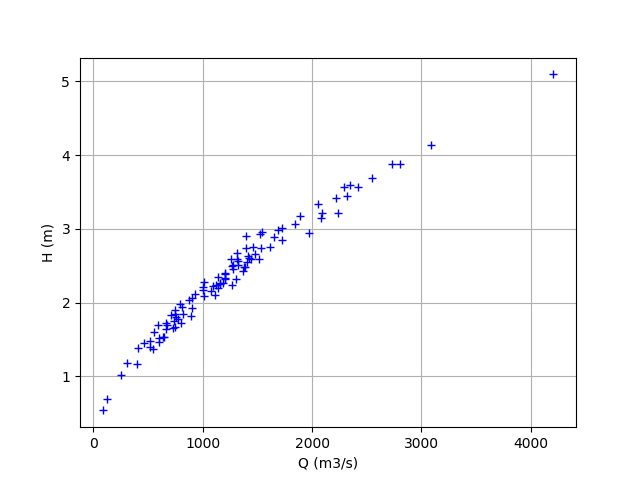

In [5]:
graph = ot.Graph('', 'Q (m3/s)', 'H (m)', True, '')
cloud = ot.Cloud(Qobs, Hobs)
cloud.setLegend("Predictions")
graph.add(cloud)
graph

In [6]:
def calibrationFunction(theta):
    Ks, Zv, Zm = theta
    Hpredicted = ot.Point(nbobs)
    for i in range(nbobs):
        X = ot.Point([Qobs[i,0],Ks, Zv, Zm])
        Hpredicted[i] = functionCrue(X)[0]
    return Hpredicted

In [7]:
calibrationG = ot.PythonFunction(3,nbobs,calibrationFunction)

Définit les bornes des variables du problème pour la variable $\theta$.

In [8]:
boundsMin = [20.,40.,40.]
boundsMax = [40.,60.,60.]
bounds = ot.Interval(boundsMin,boundsMax)

Définit le point de départ de l'algorithme d'optimisation.

In [9]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
theta0 = ot.Point([KsInitial,ZvInitial,ZmInitial])

Calcule les hauteurs d'eau prédites au point de référence.

In [10]:
Hpredicted0 = calibrationFunction(theta0)

In [11]:
labelsTheta = ("Ks (m^(1/3)/s)","Zv (m)","Zm (m)")

Calcule le gradient du modèle au point de l'ébauche.

In [12]:
H = calibrationG.gradient(theta0)

Convertit la Matrix en Sample.

In [13]:
dim = len(theta0)
Hsample = ot.Sample(nbobs,dim)
for i in range(nbobs):
    for j in range(dim):
        Hsample[i,j] = H[j,i]

Résout le problème de moindres carrés linéaires.

In [14]:
LMF = ot.LinearModelFactory()

In [15]:
deltaY = Hobs.asPoint() - Hpredicted0
deltaY = ot.Sample(deltaY,1)

In [16]:
myLeastSquares = ot.LinearLeastSquares(Hsample, deltaY)
myLeastSquares.run()

In [17]:
deltaThetaMatrix = myLeastSquares.getLinear()
deltaTheta = ot.Point(dim)
for i in range(dim):
    deltaTheta[i] = deltaThetaMatrix[i,0]
deltaTheta

class=Point name=Unnamed dimension=3 values=[0.272642,-1.36321,1.36321]

In [18]:
thetaStar = theta0 + deltaTheta
thetaStar

class=Point name=Unnamed dimension=3 values=[20.2726,47.6368,52.3632]

Calcule les hauteurs d'eau prédites au point optimal.

In [19]:
HpredictedStar = calibrationFunction(thetaStar)

Plot model versus data after calibration.

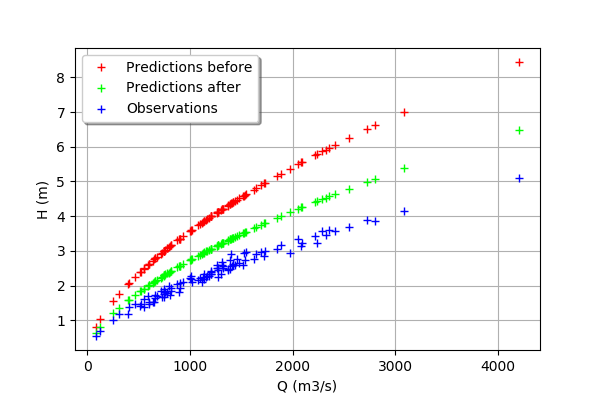

In [20]:
graph = ot.Graph('', 'Q (m3/s)', 'H (m)', True, '')
#
cloudPred0 = ot.Cloud(Qobs, ot.Sample(Hpredicted0,1))
cloudPred0.setLegend("Predictions before")
cloudPred0.setColor("red")
graph.add(cloudPred0)
#
cloudPredStar = ot.Cloud(Qobs, ot.Sample(HpredictedStar,1))
cloudPredStar.setLegend("Predictions after")
cloudPredStar.setColor("green")
graph.add(cloudPredStar)
#
cloudObs = ot.Cloud(Qobs, Hobs)
cloudObs.setColor("blue")
cloudObs.setLegend("Observations")
graph.add(cloudObs)
#
graph.setLegendPosition('topleft')
graph